In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import time

# Load data
corpus = pd.read_csv('data/cleaned_mhc.csv')

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    corpus['text'],
    corpus['label'],
    test_size=0.2,
    random_state=42
)

# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=3500)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Logistic Regression with L2 regularization and C=5
logreg = LogisticRegression(penalty='l2', C=5, solver='liblinear', random_state=42, max_iter=1000)

# Train the model
start_fit = time.time()
logreg.fit(X_train_tfidf, y_train)
fit_time = time.time() - start_fit

# Test the model
start_test = time.time()
y_train_pred = logreg.predict(X_train_tfidf)
y_test_pred = logreg.predict(X_test_tfidf)
test_time = time.time() - start_test

# Metrics
metrics = {
    'Model': ['TF-IDF + Logistic Regression (L2, C=5)'],
    'Train Accuracy': [accuracy_score(y_train, y_train_pred)],
    'Test Accuracy': [accuracy_score(y_test, y_test_pred)],
    'F1 Score': [f1_score(y_test, y_test_pred)],
    'Precision': [precision_score(y_test, y_test_pred)],
    'Recall': [recall_score(y_test, y_test_pred)],
    'Fit Time (s)': [fit_time],
    'Test Time (s)': [test_time],
    'Confusion Matrix': [confusion_matrix(y_test, y_test_pred)]
}

y_train_score = logreg.predict_proba(X_train_tfidf)[:, 1]  # Probabilities for class 1
y_test_score = logreg.predict_proba(X_test_tfidf)[:, 1]    # Probabilities for class 1

# Create the regression dataset with token names as feature names
token_features = tfidf.get_feature_names_out()

# For training set
X_train_df = pd.DataFrame(X_train_tfidf.toarray(), columns=token_features)
X_train_df['Problematic_Rate'] = y_train_score

# For test set
X_test_df = pd.DataFrame(X_test_tfidf.toarray(), columns=token_features)
X_test_df['Problematic_Rate'] = y_test_score

# Combine train and test data
regression_df = pd.concat([X_train_df, X_test_df], axis=0)

# Save to CSV
regression_df.to_csv('tfidf_regression_dataset_logreg.csv', index=False)

# Print results
results_df = pd.DataFrame(metrics)
print(results_df)

# Print Confusion Matrix
print("\nConfusion Matrices:")
print(f"TF-IDF + Logistic Regression Confusion Matrix:\n{metrics['Confusion Matrix'][0]}")

                                    Model  Train Accuracy  Test Accuracy  \
0  TF-IDF + Logistic Regression (L2, C=5)         0.95611        0.92642   

   F1 Score  Precision    Recall  Fit Time (s)  Test Time (s)  \
0  0.932757   0.934963  0.930561         0.092          0.001   

             Confusion Matrix  
0  [[1934, 165], [177, 2372]]  

Confusion Matrices:
TF-IDF + Logistic Regression Confusion Matrix:
[[1934  165]
 [ 177 2372]]


In [18]:
from sklearn.decomposition import TruncatedSVD

# Load data
corpus = pd.read_csv('data/cleaned_mhc.csv')

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    corpus['text'],
    corpus['label'],
    test_size=0.2,
    random_state=42
)

# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=3500)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Apply LSA (TruncatedSVD)
n_components = 100
lsa = TruncatedSVD(n_components=n_components, random_state=42)
X_train_lsa = lsa.fit_transform(X_train_tfidf)
X_test_lsa = lsa.transform(X_test_tfidf)

# Logistic Regression with L2 regularization and C=5
logreg_lsa = LogisticRegression(penalty='l2', C=5, solver='liblinear', random_state=42, max_iter=1000)

# Train the model
start_fit = time.time()
logreg_lsa.fit(X_train_lsa, y_train)
fit_time = time.time() - start_fit

# Test the model
start_test = time.time()
y_train_pred = logreg_lsa.predict(X_train_lsa)
y_test_pred = logreg_lsa.predict(X_test_lsa)
test_time = time.time() - start_test

# Metrics
metrics = {
    'Model': ['LSA + Logistic Regression (L2, C=5)'],
    'Train Accuracy': [accuracy_score(y_train, y_train_pred)],
    'Test Accuracy': [accuracy_score(y_test, y_test_pred)],
    'F1 Score': [f1_score(y_test, y_test_pred)],
    'Precision': [precision_score(y_test, y_test_pred)],
    'Recall': [recall_score(y_test, y_test_pred)],
    'Fit Time (s)': [fit_time],
    'Test Time (s)': [test_time],
    'Confusion Matrix': [confusion_matrix(y_test, y_test_pred)]
}

y_train_score = logreg_lsa.predict_proba(X_train_lsa)[:, 1]  # Probabilities for class 1
y_test_score = logreg_lsa.predict_proba(X_test_lsa)[:, 1]    # Probabilities for class 1

# Create the regression dataset with Topic001 to Topic100 as feature names
topic_features = [f'Topic{str(i).zfill(3)}' for i in range(1, n_components + 1)]

# For training set
X_train_df = pd.DataFrame(X_train_lsa, columns=topic_features)
X_train_df['Problematic_Rate'] = y_train_score

# For test set
X_test_df = pd.DataFrame(X_test_lsa, columns=topic_features)
X_test_df['Problematic_Rate'] = y_test_score

# Combine train and test data
regression_df = pd.concat([X_train_df, X_test_df], axis=0)

# Save to CSV
regression_df.to_csv('lsa_regression_dataset_logreg.csv', index=False)
print("Regression dataset for LSA with Logistic Regression created")

# Print results
results_df = pd.DataFrame(metrics)
print(results_df)

# Print Confusion Matrix
print("\nConfusion Matrices:")
print(f"LSA + Logistic Regression Confusion Matrix:\n{metrics['Confusion Matrix'][0]}")

Regression dataset for LSA with Logistic Regression created
                                 Model  Train Accuracy  Test Accuracy  \
0  LSA + Logistic Regression (L2, C=5)        0.912005       0.909423   

   F1 Score  Precision    Recall  Fit Time (s)  Test Time (s)  \
0   0.91711   0.920553  0.913692         0.174       0.002001   

             Confusion Matrix  
0  [[1898, 201], [220, 2329]]  

Confusion Matrices:
LSA + Logistic Regression Confusion Matrix:
[[1898  201]
 [ 220 2329]]


In [19]:
import pandas as pd
import numpy as np

tfidf_raw = pd.read_csv('tfidf_regression_dataset_logreg.csv')
y = tfidf_raw['Problematic_Rate']

# Define bins and calculate the count of samples in each bin
bin_edges = np.arange(0, 1.1, 0.1)  # Bin edges from 0 to 1 with step 0.1
bin_counts = pd.cut(y, bins=bin_edges, include_lowest=True).value_counts().sort_index()

# Convert to a DataFrame for better readability
bin_summary = pd.DataFrame({
    'Bin Range': [f"{round(interval.left, 2)} - {round(interval.right, 2)}" for interval in bin_counts.index],
    'Sample Count': bin_counts.values
})

print(bin_summary)

    Bin Range  Sample Count
0  -0.0 - 0.1          7491
1   0.1 - 0.2          1408
2   0.2 - 0.3           778
3   0.3 - 0.4           481
4   0.4 - 0.5           448
5   0.5 - 0.6           460
6   0.6 - 0.7           542
7   0.7 - 0.8           739
8   0.8 - 0.9          1310
9   0.9 - 1.0          9583


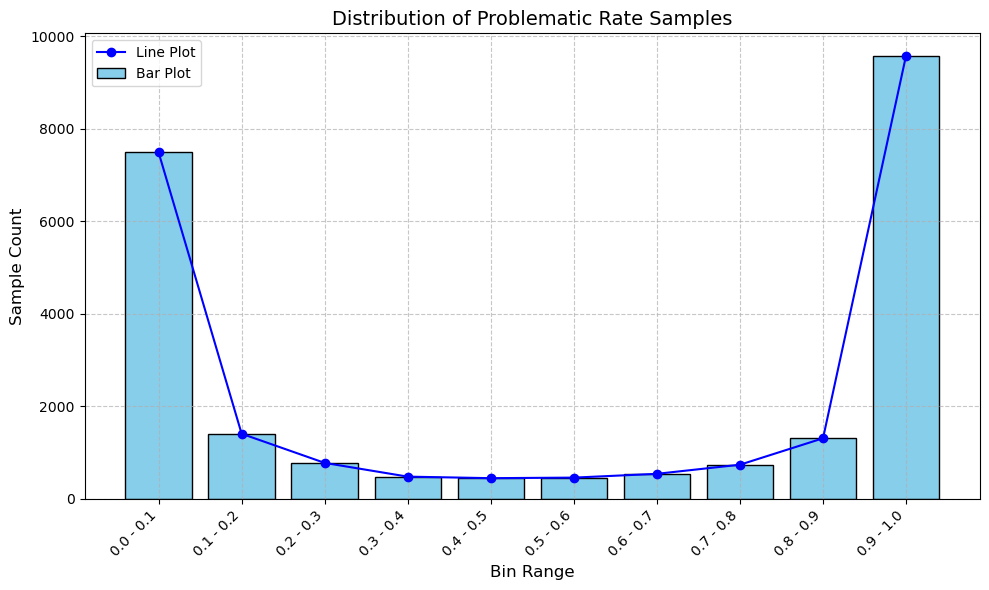

In [20]:
import matplotlib.pyplot as plt

# Extract bin ranges and sample counts
bin_ranges = bin_summary['Bin Range']
sample_counts = bin_summary['Sample Count']

# Correct the first bin label to show 0.0 instead of -0.0
bin_ranges = [label.replace('-0.0', '0.0') for label in bin_ranges]

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(bin_ranges, sample_counts, color='skyblue', edgecolor='black', label='Bar Plot')

# Add a continuous line intersecting the top of each bar
x_positions = range(len(bin_ranges))
plt.plot(x_positions, sample_counts, color='blue', marker='o', linestyle='-', label='Line Plot')

# Add vertical and horizontal grid lines
plt.grid(axis='both', linestyle='--', alpha=0.7)

# Add labels and title
plt.xlabel('Bin Range', fontsize=12)
plt.ylabel('Sample Count', fontsize=12)
plt.title('Distribution of Problematic Rate Samples', fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(ticks=x_positions, labels=bin_ranges, rotation=45, ha='right')

# Add a legend
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

         Bin Range  Sample Count
0  -13.04 - -10.36            24
1   -10.36 - -7.67           408
2    -7.67 - -4.98          1939
3     -4.98 - -2.3          4917
4      -2.3 - 0.39          3757
5      0.39 - 3.07          4055
6      3.07 - 5.76          4765
7      5.76 - 8.44          2640
8     8.44 - 11.13           676
9    11.13 - 13.82            59


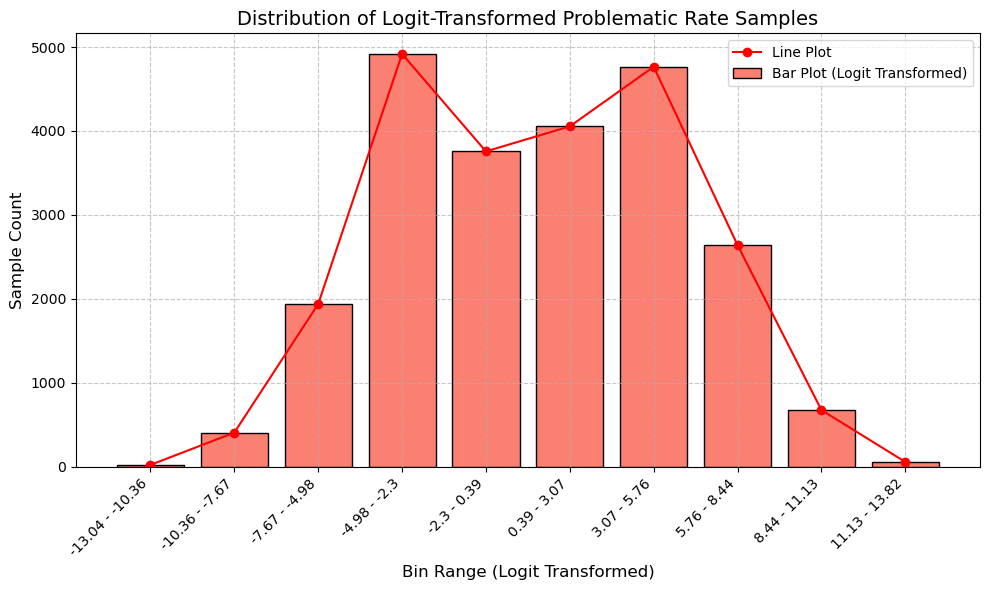

'tfidf_regression_dataset_logreg_transformed.csv'

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the original dataset
tfidf_raw = pd.read_csv('tfidf_regression_dataset_logreg.csv')
y = tfidf_raw['Problematic_Rate']

# Define the lower and upper bounds for logit transformation
a, b = 0, 1
epsilon = 1e-6  # Small value to prevent undefined values

# Apply the logit transformation
y_clipped = np.clip(y, a + epsilon, b - epsilon)
y_logit = np.log((y_clipped - a) / (b - y_clipped))

# Create bins for the transformed data
bin_edges_logit = np.linspace(y_logit.min(), y_logit.max(), 11)  # 10 equal bins
bin_counts_logit = pd.cut(y_logit, bins=bin_edges_logit, include_lowest=True).value_counts().sort_index()

# Convert to a DataFrame for readability
bin_summary_logit = pd.DataFrame({
    'Bin Range': [f"{round(interval.left, 2)} - {round(interval.right, 2)}" for interval in bin_counts_logit.index],
    'Sample Count': bin_counts_logit.values
})

# Display the bin summary
print(bin_summary_logit)

# Visualization of the transformed distribution
plt.figure(figsize=(10, 6))
bin_ranges_logit = bin_summary_logit['Bin Range']
sample_counts_logit = bin_summary_logit['Sample Count']

# Plot bar chart
plt.bar(bin_ranges_logit, sample_counts_logit, color='salmon', edgecolor='black', label='Bar Plot (Logit Transformed)')

# Add line plot over the bar plot
x_positions_logit = range(len(bin_ranges_logit))
plt.plot(x_positions_logit, sample_counts_logit, color='red', marker='o', linestyle='-', label='Line Plot')

# Add vertical and horizontal grid lines
plt.grid(axis='both', linestyle='--', alpha=0.7)

# Add labels and title
plt.xlabel('Bin Range (Logit Transformed)', fontsize=12)
plt.ylabel('Sample Count', fontsize=12)
plt.title('Distribution of Logit-Transformed Problematic Rate Samples', fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(ticks=x_positions_logit, labels=bin_ranges_logit, rotation=45, ha='right')

# Add a legend
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

# Replace the 'Problematic_Rate' column with the logit-transformed values and save the dataset
tfidf_raw['Problematic_Rate'] = y_logit
transformed_filepath = 'tfidf_regression_dataset_logreg_transformed.csv'
tfidf_raw.to_csv(transformed_filepath, index=False)

transformed_filepath

In [22]:
import pandas as pd
import numpy as np

lsa_raw = pd.read_csv('lsa_regression_dataset_logreg.csv')
y = lsa_raw['Problematic_Rate']

# Define bins and calculate the count of samples in each bin
bin_edges = np.arange(0, 1.1, 0.1)  # Bin edges from 0 to 1 with step 0.1
bin_counts = pd.cut(y, bins=bin_edges, include_lowest=True).value_counts().sort_index()

# Convert to a DataFrame for better readability
bin_summary = pd.DataFrame({
    'Bin Range': [f"{round(interval.left, 2)} - {round(interval.right, 2)}" for interval in bin_counts.index],
    'Sample Count': bin_counts.values
})

print(bin_summary)

    Bin Range  Sample Count
0  -0.0 - 0.1          6504
1   0.1 - 0.2          1831
2   0.2 - 0.3          1034
3   0.3 - 0.4           753
4   0.4 - 0.5           657
5   0.5 - 0.6           604
6   0.6 - 0.7           636
7   0.7 - 0.8           859
8   0.8 - 0.9          1375
9   0.9 - 1.0          8987


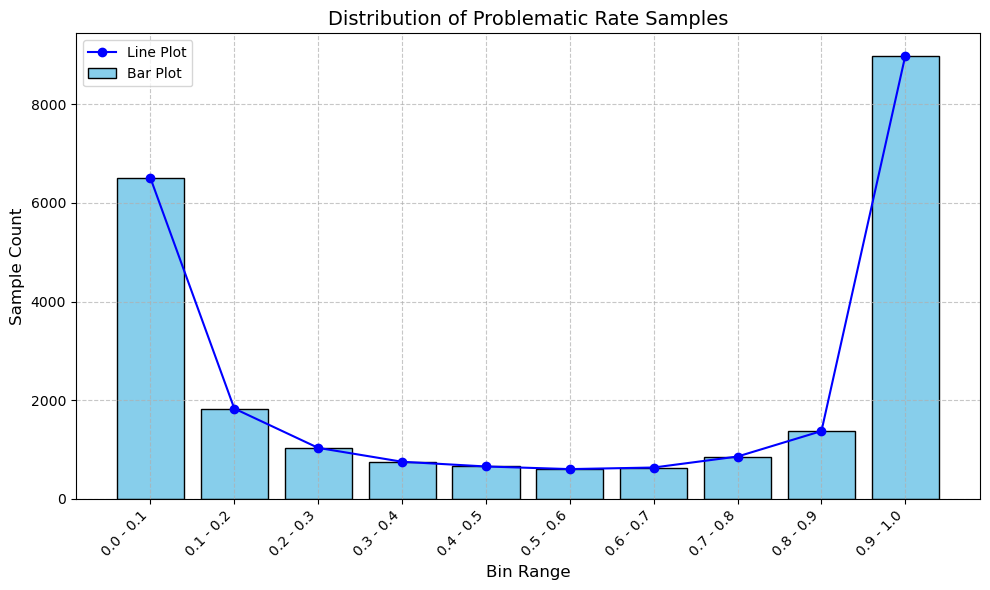

In [23]:
import matplotlib.pyplot as plt

# Extract bin ranges and sample counts
bin_ranges = bin_summary['Bin Range']
sample_counts = bin_summary['Sample Count']

# Correct the first bin label to show 0.0 instead of -0.0
bin_ranges = [label.replace('-0.0', '0.0') for label in bin_ranges]

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(bin_ranges, sample_counts, color='skyblue', edgecolor='black', label='Bar Plot')

# Add a continuous line intersecting the top of each bar
x_positions = range(len(bin_ranges))
plt.plot(x_positions, sample_counts, color='blue', marker='o', linestyle='-', label='Line Plot')

# Add vertical and horizontal grid lines
plt.grid(axis='both', linestyle='--', alpha=0.7)

# Add labels and title
plt.xlabel('Bin Range', fontsize=12)
plt.ylabel('Sample Count', fontsize=12)
plt.title('Distribution of Problematic Rate Samples', fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(ticks=x_positions, labels=bin_ranges, rotation=45, ha='right')

# Add a legend
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

         Bin Range  Sample Count
0  -13.13 - -10.43            30
1   -10.43 - -7.74           335
2    -7.74 - -5.04          1242
3    -5.04 - -2.35          4477
4     -2.35 - 0.34          5209
5      0.34 - 3.04          4479
6      3.04 - 5.73          4695
7      5.73 - 8.43          2289
8     8.43 - 11.12           443
9    11.12 - 13.82            41


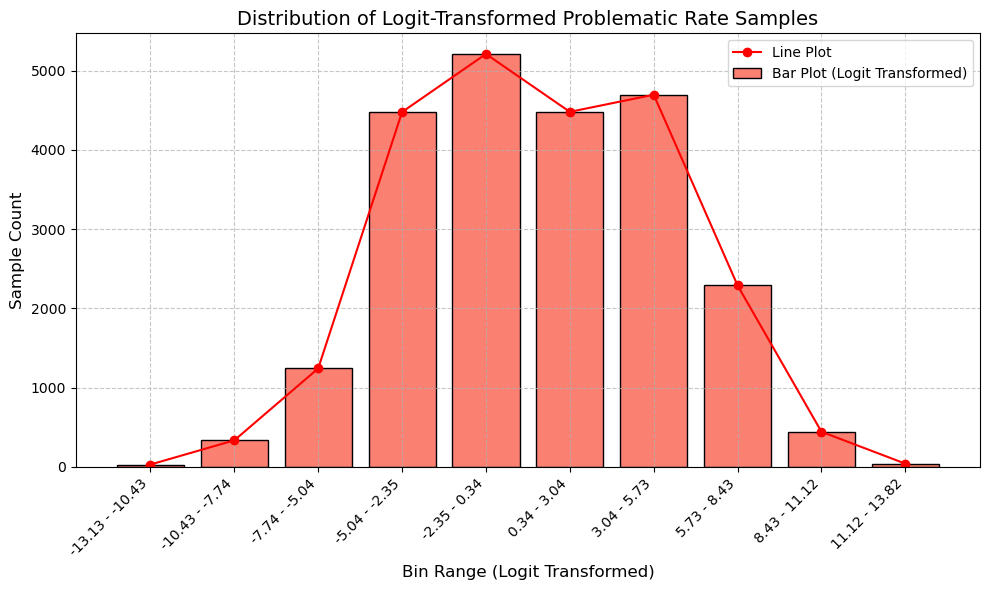

'lsa_regression_dataset_logreg_transformed.csv'

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the original dataset
tfidf_raw = pd.read_csv('lsa_regression_dataset_logreg.csv')
y = tfidf_raw['Problematic_Rate']

# Define the lower and upper bounds for logit transformation
a, b = 0, 1
epsilon = 1e-6  # Small value to prevent undefined values

# Apply the logit transformation
y_clipped = np.clip(y, a + epsilon, b - epsilon)
y_logit = np.log((y_clipped - a) / (b - y_clipped))

# Create bins for the transformed data
bin_edges_logit = np.linspace(y_logit.min(), y_logit.max(), 11)  # 10 equal bins
bin_counts_logit = pd.cut(y_logit, bins=bin_edges_logit, include_lowest=True).value_counts().sort_index()

# Convert to a DataFrame for readability
bin_summary_logit = pd.DataFrame({
    'Bin Range': [f"{round(interval.left, 2)} - {round(interval.right, 2)}" for interval in bin_counts_logit.index],
    'Sample Count': bin_counts_logit.values
})

# Display the bin summary
print(bin_summary_logit)

# Visualization of the transformed distribution
plt.figure(figsize=(10, 6))
bin_ranges_logit = bin_summary_logit['Bin Range']
sample_counts_logit = bin_summary_logit['Sample Count']

# Plot bar chart
plt.bar(bin_ranges_logit, sample_counts_logit, color='salmon', edgecolor='black', label='Bar Plot (Logit Transformed)')

# Add line plot over the bar plot
x_positions_logit = range(len(bin_ranges_logit))
plt.plot(x_positions_logit, sample_counts_logit, color='red', marker='o', linestyle='-', label='Line Plot')

# Add vertical and horizontal grid lines
plt.grid(axis='both', linestyle='--', alpha=0.7)

# Add labels and title
plt.xlabel('Bin Range (Logit Transformed)', fontsize=12)
plt.ylabel('Sample Count', fontsize=12)
plt.title('Distribution of Logit-Transformed Problematic Rate Samples', fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(ticks=x_positions_logit, labels=bin_ranges_logit, rotation=45, ha='right')

# Add a legend
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

# Replace the 'Problematic_Rate' column with the logit-transformed values and save the dataset
tfidf_raw['Problematic_Rate'] = y_logit
transformed_filepath = 'lsa_regression_dataset_logreg_transformed.csv'
tfidf_raw.to_csv(transformed_filepath, index=False)

transformed_filepath


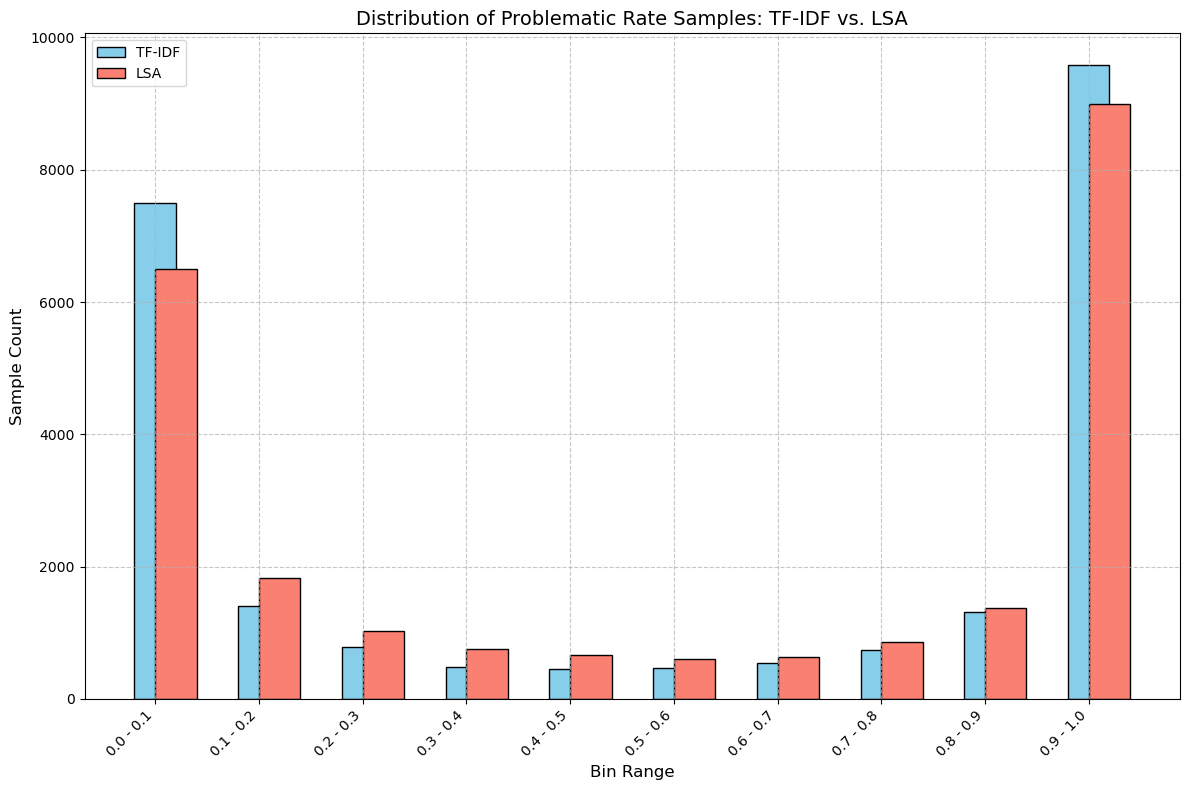

In [26]:
import pandas as pd
import numpy as np

tfidf_raw = pd.read_csv('tfidf_regression_dataset_logreg.csv')
y_tfidf = tfidf_raw['Problematic_Rate']
lsa_raw = pd.read_csv('lsa_regression_dataset_logreg.csv')
y_lsa = lsa_raw['Problematic_Rate']

# Define bins and calculate counts for tfidf data
bin_edges = np.arange(0, 1.1, 0.1)  # Bin edges from 0 to 1 with step 0.1
bin_counts_tfidf = pd.cut(y_tfidf, bins=bin_edges, include_lowest=True).value_counts().sort_index()

# Define bins and calculate counts for lsa data
bin_counts_lsa = pd.cut(y_lsa, bins=bin_edges, include_lowest=True).value_counts().sort_index()

# Create a DataFrame for better readability
bin_summary_tfidf = pd.DataFrame({
    'Bin Range': [f"{round(interval.left, 2)} - {round(interval.right, 2)}" for interval in bin_counts_tfidf.index],
    'Sample Count': bin_counts_tfidf.values
})

bin_summary_lsa = pd.DataFrame({
    'Bin Range': [f"{round(interval.left, 2)} - {round(interval.right, 2)}" for interval in bin_counts_lsa.index],
    'Sample Count': bin_counts_lsa.values
})

# Extract bin ranges and sample counts for both datasets
bin_ranges_tfidf = bin_summary_tfidf['Bin Range']
sample_counts_tfidf = bin_summary_tfidf['Sample Count']
bin_ranges_lsa = bin_summary_lsa['Bin Range']
sample_counts_lsa = bin_summary_lsa['Sample Count']

# Correct the first bin label to show 0.0 instead of -0.0
bin_ranges_tfidf = [label.replace('-0.0', '0.0') for label in bin_ranges_tfidf]
bin_ranges_lsa = [label.replace('-0.0', '0.0') for label in bin_ranges_lsa]

# Create a combined bar plot
plt.figure(figsize=(12, 8))

# Bar plots for both datasets
plt.bar(bin_ranges_tfidf, sample_counts_tfidf, color='skyblue', edgecolor='black', width=0.4, label='TF-IDF', align='center')
plt.bar(bin_ranges_lsa, sample_counts_lsa, color='salmon', edgecolor='black', width=0.4, label='LSA', align='edge')

# Add a legend
plt.legend()

# Add vertical and horizontal grid lines
plt.grid(axis='both', linestyle='--', alpha=0.7)

# Add labels and title
plt.xlabel('Bin Range', fontsize=12)
plt.ylabel('Sample Count', fontsize=12)
plt.title('Distribution of Problematic Rate Samples: TF-IDF vs. LSA', fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Display the plot
plt.tight_layout()
plt.show()